In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pyspark.sql.functions as f
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Credit_Card_Fraud") \
    .config("spark.sql.debug.maxToStringFields", "200") \
    .getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/25 11:16:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load file
df = spark.read.csv('datasets/creditcard.csv', header=True, inferSchema=True, sep=",")

# Print Schema
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [3]:
aux_df = df.limit(10).toPandas()
aux_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Spark DataFrame Shape
print(f"Number of columns: {len(df.columns)}")
print(f"Number of Records: {df.count()}")

Number of columns: 31
Number of Records: 284807


In [5]:
# All columns
df.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.205498e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406306e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [6]:
# Only Amount and Class Columns
df.select("Amount", "Class").toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
Amount,284807.0,88.349619,250.120109,0.0,5.6,22.0,77.165,25691.16
Class,284807.0,0.001727,0.041527,0.0,0.0,0.0,0.000,1.00


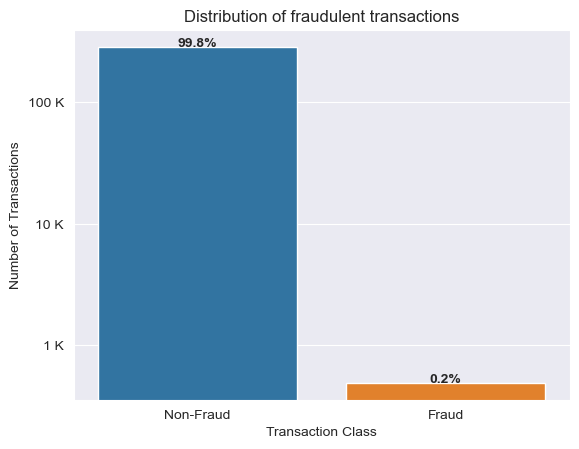

In [7]:
fraud_df = df.select("Class").toPandas()

# Count the number of transactions for each class (fraudulent or not)
fraud_counts = fraud_df['Class'].value_counts()

# Calculate the percentage of each class
fraud_perc = fraud_counts / fraud_counts.sum() * 100

# Create a bar plot with logarithmic y-axis
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.yscale('log')

# Add percentage labels to the bars
for i, v in enumerate(fraud_counts):
    plt.text(i, v, f"{fraud_perc[i]:.1f}%", ha='center', fontweight='bold')

# Set the y-axis labels and formatter
plt.ylabel('Number of Transactions')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f} K'.format(x/1000)))

# Set the axis labels and title
plt.xlabel('Transaction Class')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.title('Distribution of fraudulent transactions')

plt.show()

In [8]:
fraud_counts

0    284315
1       492
Name: Class, dtype: int64

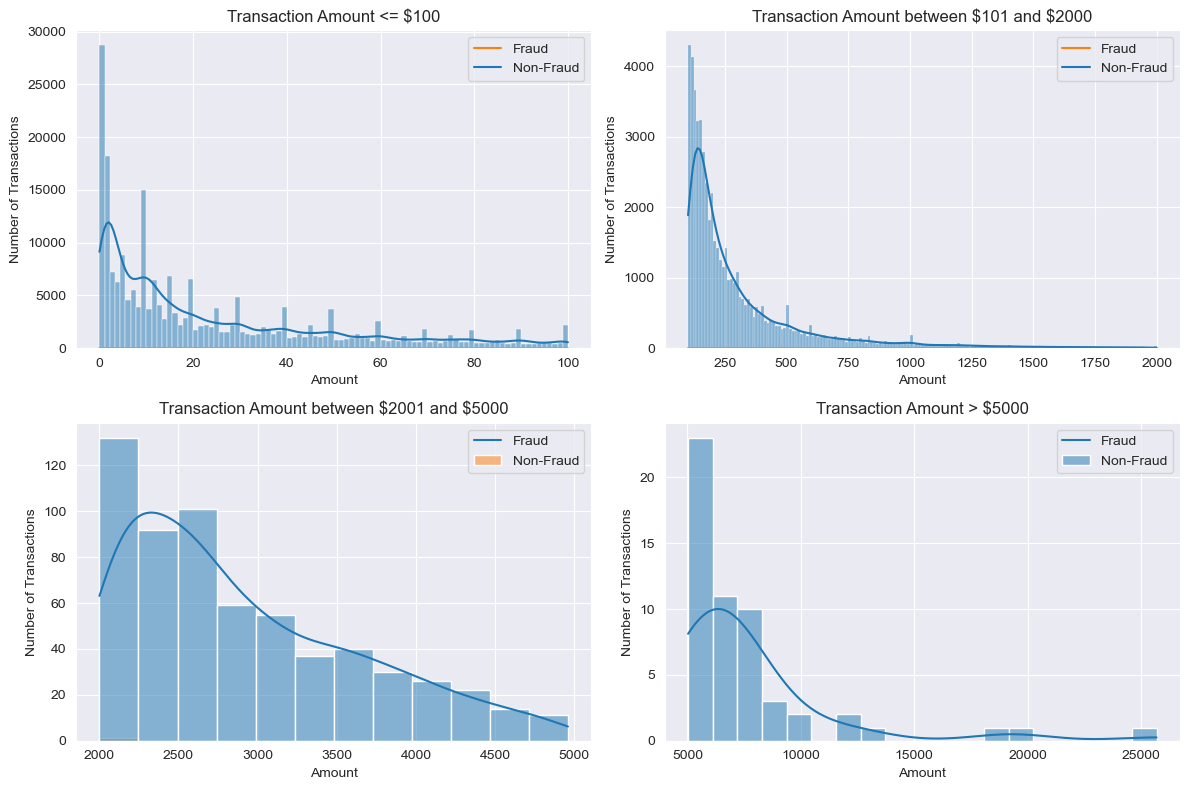

In [9]:
# All Transactions
df_aux = df.select("Class", "Amount").toPandas()

# Define amount ranges
amount_ranges = [
    {"range": "Transaction Amount <= $100", "min_amount": 0, "max_amount": 100},
    {"range": "Transaction Amount between \$101 and \$2000", "min_amount": 101, "max_amount": 2000},
    {"range": "Transaction Amount between \$2001 and \$5000", "min_amount": 2001, "max_amount": 5000},
    {"range": "Transaction Amount > $5000", "min_amount": 5001, "max_amount": df_aux["Amount"].max()}
]

# Create four subplots for different amount ranges
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for idx, amount_range in enumerate(amount_ranges):
    row_idx = idx // 2
    col_idx = idx % 2

    # Filter transactions within amount range
    df_range = df_aux[(df_aux["Amount"] > amount_range["min_amount"]) & (df_aux["Amount"] <= amount_range["max_amount"])]

    # Plot histogram
    sns.histplot(data=df_range, x="Amount", ax=axes[row_idx, col_idx], hue="Class", kde=True)
    axes[row_idx, col_idx].set_title(amount_range["range"])
    axes[row_idx, col_idx].set_ylabel("Number of Transactions")
    axes[row_idx, col_idx].legend(labels=["Fraud", "Non-Fraud"])

plt.tight_layout()
plt.show()

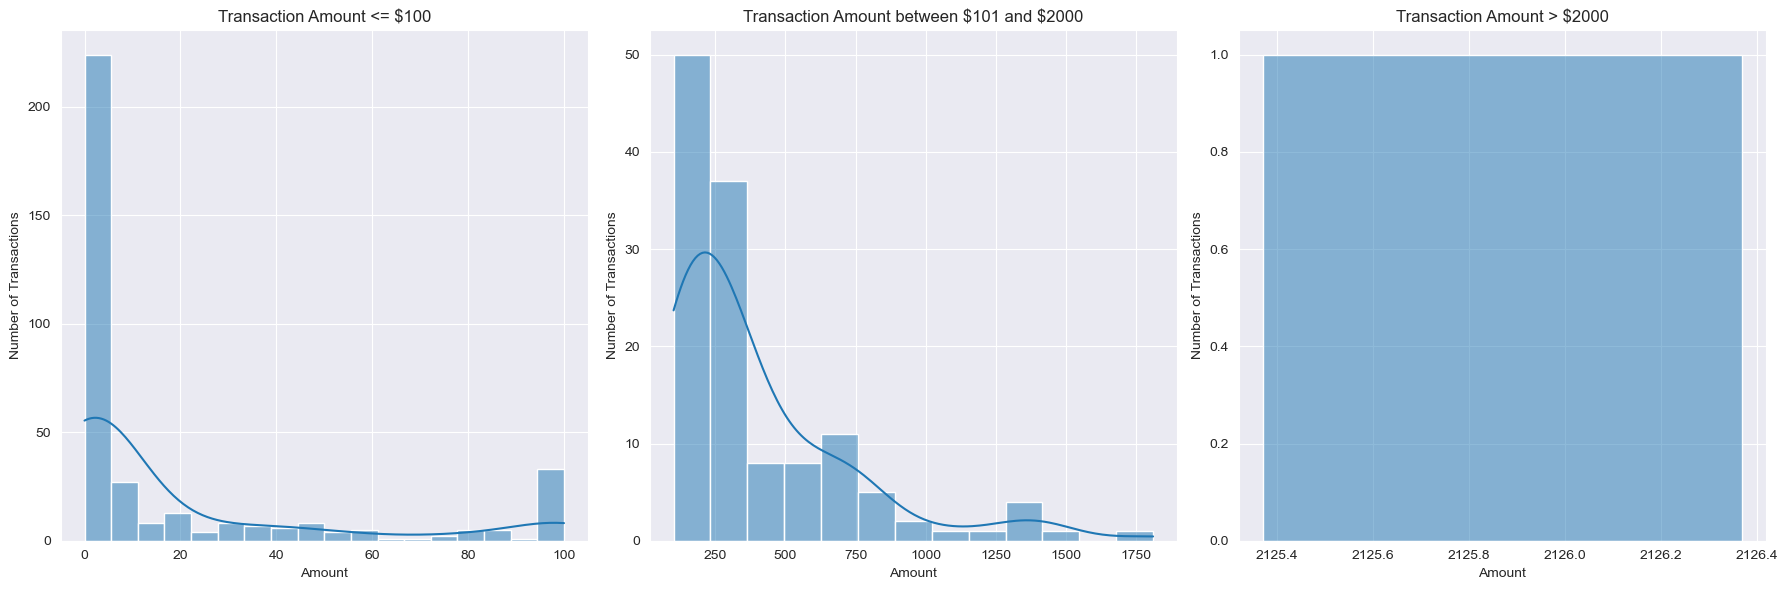

In [10]:
# Only fraud transactions
only_fraud = df.filter(df.Class == 1).select("Amount").toPandas()

# Create three subplots for different amount ranges
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Amount range <= 100
sns.histplot(data=only_fraud[only_fraud["Amount"] <= 100], x="Amount", ax=axes[0], kde=True)
axes[0].set_title("Transaction Amount <= $100")
axes[0].set_ylabel("Number of Transactions")

# Amount range <= 2000
sns.histplot(data=only_fraud[(only_fraud["Amount"] > 100) & (only_fraud["Amount"] <= 2000)], x="Amount", ax=axes[1], kde=True)
axes[1].set_title("Transaction Amount between \$101 and \$2000")
axes[1].set_ylabel("Number of Transactions")

# Amount range > 2000
sns.histplot(data=only_fraud[only_fraud["Amount"] > 2000], x="Amount", ax=axes[2], kde=True)
axes[2].set_title("Transaction Amount > $2000")
axes[2].set_ylabel("Number of Transactions")

plt.tight_layout()
plt.show()
